In [1]:
# Udacity Lab exercie functions

from features import *
from Window_Sliding_and_Markers import *
from Search_and_Classify import *
from plot3D import *
from my_func import *



In [2]:
# Dependencies
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

### Organize Images

In [3]:
# Here is a list of image links as text files is produced for easier access at a later point.

## For images of Cars
dir_cars = 'vehicles/'
img_orientation = os.listdir(dir_cars)

# Read in image names
cars = []
for imgs in img_orientation:
    cars.extend(glob.glob(dir_cars+imgs+'/*.png'))
    
# Write to a txt file for easy access to image titles
with open("cars.txt",'w') as f:
    for filenames in cars:
        f.write(filenames+'\n')

## For images that are not Cars
dir_not_cars =  'non-vehicles/'
folders = os.listdir(dir_not_cars)

# notcars data
notcars = []
for imgs in folders:
    notcars.extend(glob.glob(dir_not_cars+imgs+'/*.png'))
with open("notcars.txt",'w') as f:
    for filenames in notcars:
        f.write(filenames+'\n')    


### Ideal Color Space

In [4]:
# These are tests done to achieve statistical confidence in the Color Space being used.
ac_DF = get_best_color_space(cars, notcars)

Done with Test :  0
Done with Test :  1
Done with Test :  2
Done with Test :  3
Done with Test :  4
Done with Test :  5
Done with Test :  6
Done with Test :  7
Done with Test :  8
Done with Test :  9
All tests done.


In [5]:
# This Data Frame is used to record the test results, YUV seems to perform consistently well and
# RGB is the least consistent. HLS, YCrCb are virtually identical in performance.
ac_DF

,RGB,HSV,LUV,HLS,YUV,YCrCb
0,0.95,0.99,0.97,0.97,0.99,0.99
1,0.95,0.98,0.99,0.99,0.99,0.99
2,0.97,0.95,0.99,0.98,0.99,0.98
3,0.91,0.98,0.97,1.00,0.98,0.96
4,0.98,0.97,0.99,0.97,0.98,1.00
5,0.95,1.00,0.99,0.95,0.99,1.00
6,0.95,0.99,0.99,0.98,0.98,0.99
7,0.98,1.00,0.98,0.99,0.99,0.99
8,0.96,0.98,0.96,0.98,0.97,0.96
9,0.95,0.96,0.99,0.99,0.99,0.98


In [7]:
# Get the max mean from accuracies of all tests
# Color space list
color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']

best_Color_Space = ac_DF[color_spaces].mean().idxmax()
best_Color_Space

'YUV'

### Train Classifier

In [8]:

# time to calculate total time for traiing
t= time.time()

# juggling variable names
test_cars = cars
test_notcars = notcars

# Parameters
color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

# Extract all features [Spacial, Histogram, Histogram of Gradients, and ColorSpace]
car_features = extract_features(test_cars, color_space=color_space, spatial_size= spatial_size,
                            hist_bins= hist_bins, orient= orient, 
                            pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                            spatial_feat= spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, spatial_size= spatial_size,
                            hist_bins= hist_bins, orient= orient, 
                            pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, hog_channel= hog_channel,
                            spatial_feat= spatial_feat, hist_feat= hist_feat, hog_feat= hog_feat)

# Format for standard scaler input
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Standard Scaler where the input is normalized
X_scalar =  StandardScaler().fit(X)
scaled_X = X_scalar.transform(X)

# Only two possible predictions zeros for notcars and 1 for cars
y =  np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size =0.1)

# Using SVC 
svc = LinearSVC()

# Training
svc.fit(X_train,y_train)
print('Done training, Total training time : ', round(time.time()-t,3))

Done training, Total training time :  83.379


['test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']
0.0 1.0
0.9734976291656494  seconds to process image searching  240  windows
0.0 1.0
1.8994972705841064  seconds to process image searching  240  windows
0.0 1.0
2.8274991512298584  seconds to process image searching  240  windows
0.0 1.0
3.710498094558716  seconds to process image searching  240  windows
0.0 1.0
4.607497692108154  seconds to process image searching  240  windows
0.0 1.0
5.481997728347778  seconds to process image searching  240  windows


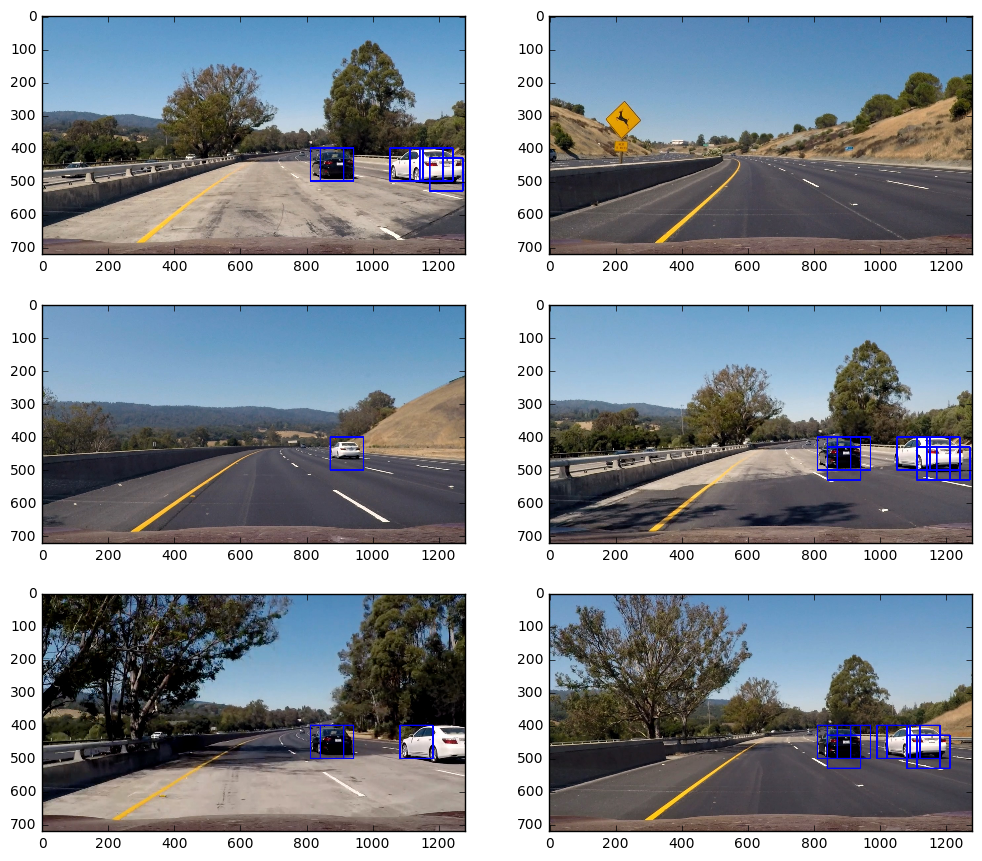

In [9]:
# Testing with test images provided by Udacity
test_img_dir = "test_images/*"
test_window_imgs = glob.glob(test_img_dir)
print(test_window_imgs)
images = []
titles = []

# Establish region of image to be searched and other parameters
y_start_stop = [400,656]
overlap = 0.7
window_size = (100, 100)

t= time.time()

# Detect cars in the test images
for img_src in test_window_imgs:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop= y_start_stop, 
                    xy_window= window_size, xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scalar, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins= hist_bins, orient= orient, 
                                    pix_per_cell= pix_per_cell, cell_per_block= cell_per_block, 
                                    hog_channel= hog_channel, spatial_feat= spatial_feat, 
                                    hist_feat= hist_feat, hog_feat= hog_feat)

    window_img = draw_boxes(draw_img, hot_windows, color = (0,0,255), thick=3)
    images.append(window_img)
    titles.append('')
    print(time.time()-t, ' seconds to process image searching ', len(windows), ' windows')
    
fig = plt.figure(figsize=(12,18), dpi = 300)
visualize(fig,5,2,images, titles)

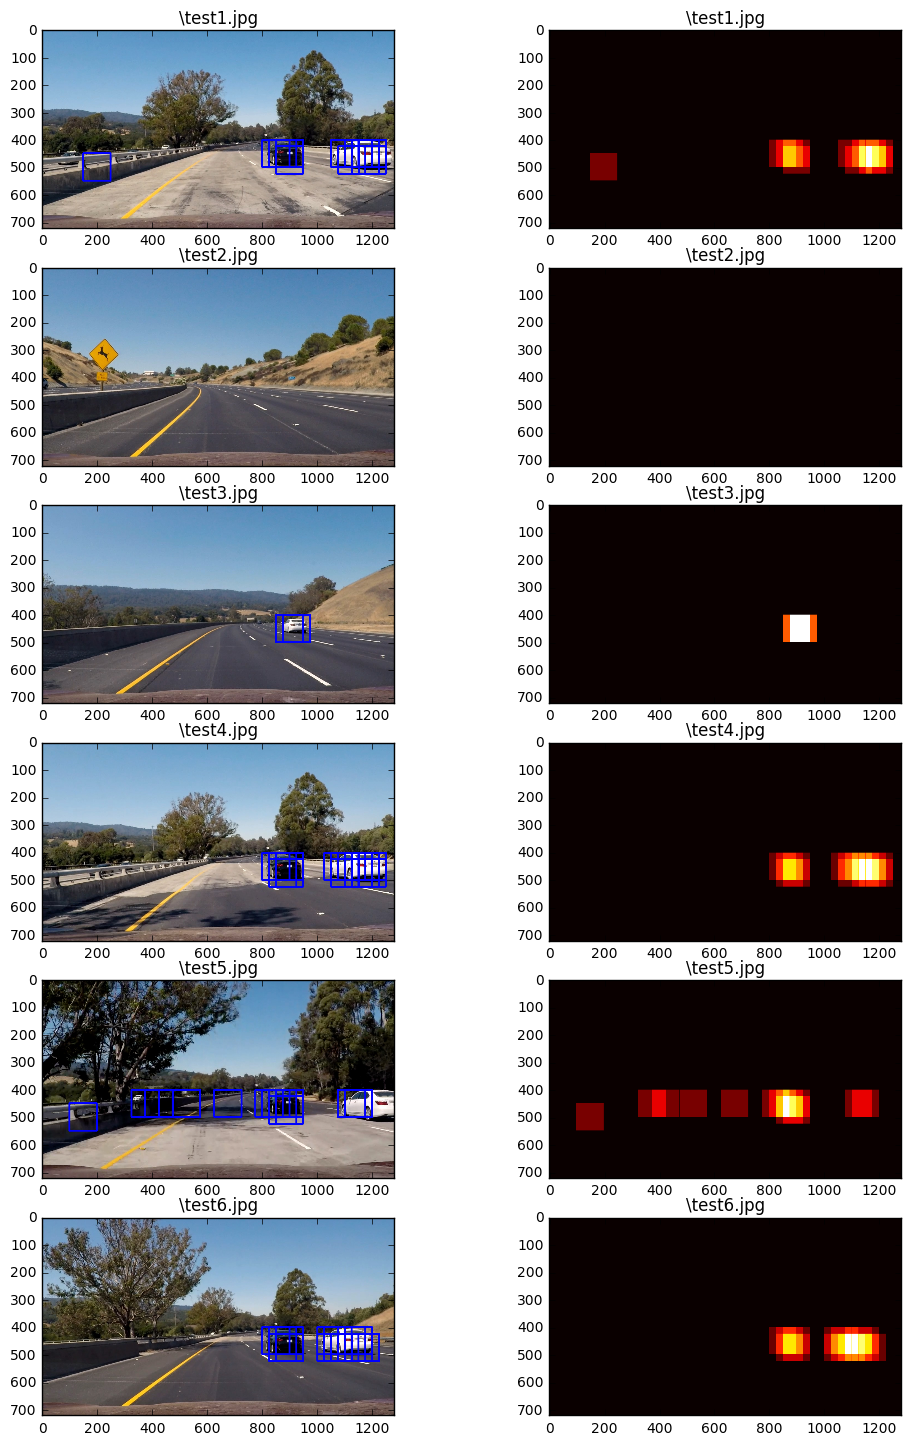

In [10]:
# This is a function that takes in a image or image links, detects cars and returns heat maps 
# where the cars are detected
def get_hmaps(img_src,scale):
    # string link or image gate
    if type(img_src) == type('string'):
        img = mpimg.imread(img_src)
    else:
        img = img_src
    img_boxes=[]
    
    # empty heat map
    heatmap = np.zeros_like(img[:,:,0])
    # clean image
    draw_img = np.copy(img)
    # scale .jpg 
    img = img.astype(np.float32)/255
    
    # slice of image
    img_tosearch = img[ystart:ystop,:,:]
    # convert the slice
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    # scale correction if less than 64
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # All three channels stored seperatly for HOG extraction
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    #Subsampling begins here
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scalar.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            # If car detected draw box and add heat to heat map at the detected locations
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
    return draw_img, heatmap
# Empty lists
out_images = []
out_maps = []
out_titles = []
out_boxes = []

# Parameters
ystart = 400
ystop = 656
scale = 1.56

# Visualize Heat maps
for img_src in test_window_imgs:
    draw_imgs, heatmaps = get_hmaps(img_src,scale)
    out_images.append(draw_imgs)
    out_images.append(heatmaps)
    out_titles.append(img_src[-10:])
    out_titles.append(img_src[-10:])
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)

In [11]:
# threshholds heatmap
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold]=0
    return heatmap

# Picks the max and mins of box clusters and makes one big box
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        minx = np.min(nonzerox)
        miny = np.min(nonzeroy)
        maxx = np.max(nonzerox)
        maxy = np.max(nonzeroy)
        
        bbox = ((int(minx), int(miny)), (int(maxx), int(maxy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 2)
    # Return the image
    return img

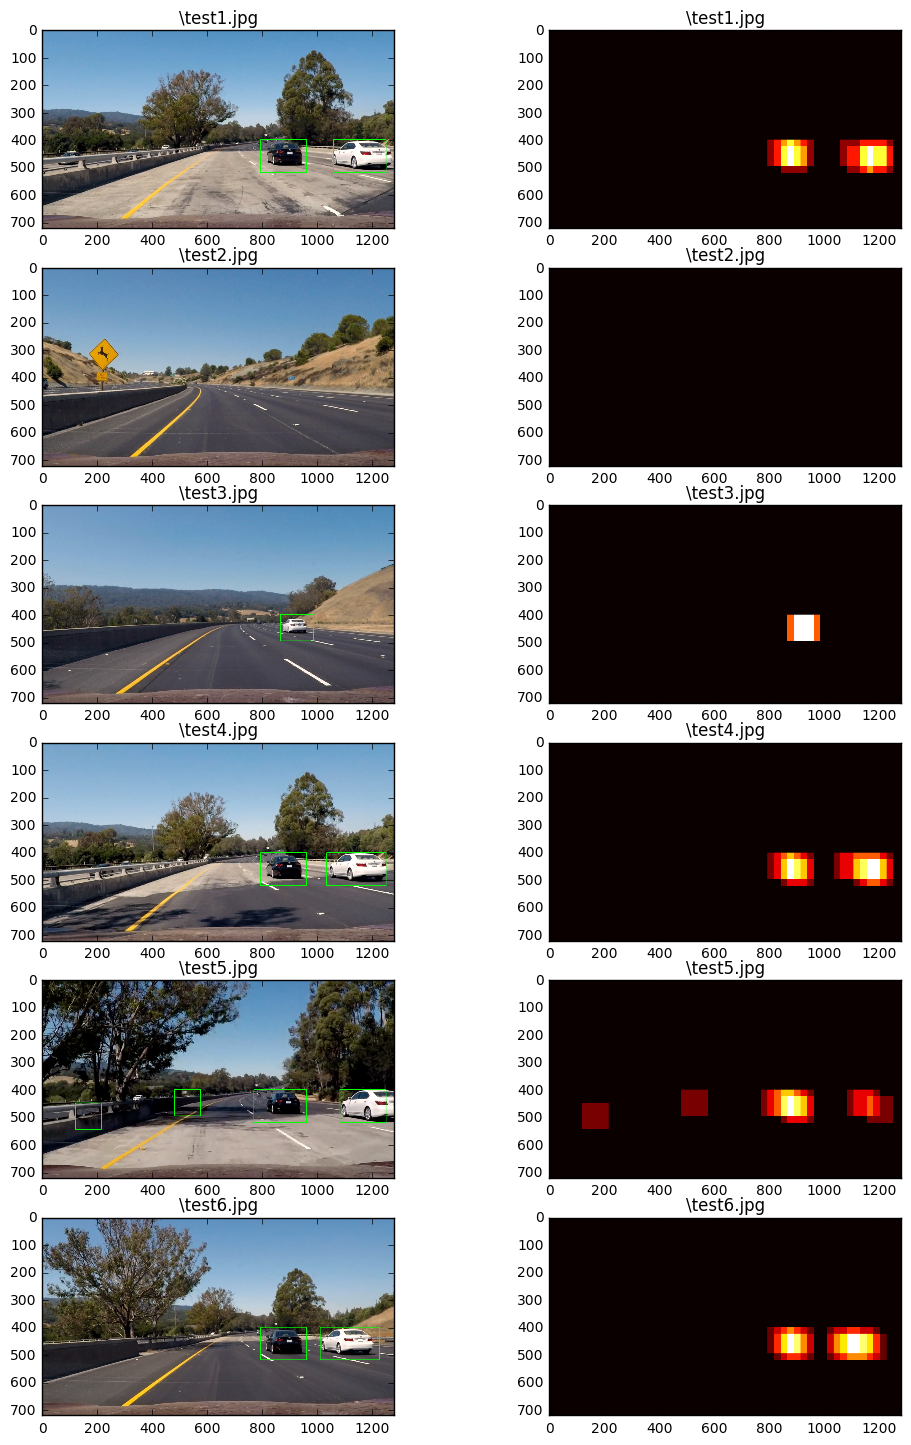

In [12]:
# Removing extrax oxes
out_images = []
out_maps = []
out_titles = []
scale =1.5

# Simply looping through functions above
for img_src in test_window_imgs:
    out_img, heat_maps = get_hmaps(img_src,scale)
    heat_maps = apply_threshold(heat_maps, 0.8)
    labels = label(heat_maps)
    
    img = mpimg.imread(img_src)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_images.append(heat_maps)
    
    out_titles.append(img_src[-10:])
    out_titles.append(img_src[-10:])
    
# plot the results
fig = plt.figure(figsize=(12,24))
visualize(fig,8,2,out_images,out_titles)

In [13]:
# Pipeline for Video Processing
def process_image(img):
    scale = 1.56
    out_img, heat_map = get_hmaps(img,scale)
    heat_map = apply_threshold(heat_map, .9)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'output.mp4'
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(process_image)

output_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:22<00:00,  4.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

